# MiniGPT

In [ ]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

In [ ]:
import keras
import pathlib

extract_dir = keras.utils.get_file(
    fname="mini-c4",
    origin=(
        "https://hf.co/datasets/mattdangerw/mini-c4/resolve/main/mini-c4.zip"
    ),
    extract=True,
)
extract_dir = pathlib.Path(extract_dir) / "mini-c4"

In [ ]:
with open(extract_dir / "shard0.txt", "r") as f:
    print(f.readline().replace("\\n", "\n")[:100])

Beginners BBQ Class Taking Place in Missoula!
Do you want to get better at making delicious BBQ? You


In [ ]:
import keras_hub
import numpy as np

vocabulary_file = keras.utils.get_file(
    origin="https://hf.co/mattdangerw/spiece/resolve/main/vocabulary.proto",
)

In [ ]:
tokenizer = keras_hub.tokenizers.SentencePieceTokenizer(vocabulary_file)

In [ ]:
tokenizer.tokenize("The quick bron fox.")

<tf.Tensor: shape=(6,), dtype=int32, numpy=array([  450,  4996, 12246,  1701, 29916, 29889], dtype=int32)>

In [ ]:
tokenizer.detokenize([450, 4996, 12246, 1701, 29916, 29889])

'The quick bron fox.'

In [ ]:
import tensorflow as tf

batch_size = 128
sequence_length = 256
suffix = np.array([tokenizer.token_to_id("<|endoftext|>")])

def read_file(filename):
    ds = tf.data.TextLineDataset(filename)
    ds = ds.map(lambda x: tf.strings.regex_replace(x, r"\\n", "\n"))
    ds = ds.map(tokenizer, num_parallel_calls=8)
    return ds.map(lambda x: tf.concat([x, suffix], -1))

files = [str(file) for file in extract_dir.glob("*.txt")]
ds = tf.data.Dataset.from_tensor_slices(files)
ds = ds.interleave(read_file, cycle_length=32, num_parallel_calls=32)
ds = ds.rebatch(sequence_length + 1, drop_remainder=True)
ds = ds.map(lambda x: (x[:-1], x[1:]))
ds = ds.batch(batch_size).prefetch(8)

In [ ]:
num_batches = 29373
num_val_batches = 500
num_train_batches = num_batches - num_val_batches
val_ds = ds.take(num_val_batches).repeat()
train_ds = ds.skip(num_val_batches).repeat()

In [ ]:
from keras import layers

class TransformerDecoder(keras.Layer):
    def __init__(self, hidden_dim, intermediate_dim, num_heads):
        super().__init__()
        key_dim = hidden_dim // num_heads
        self.self_attention = layers.MultiHeadAttention(
            num_heads, key_dim, dropout=0.1
        )
        self.self_attention_layernorm = layers.LayerNormalization()
        self.feed_forward_1 = layers.Dense(intermediate_dim, activation="relu")
        self.feed_forward_2 = layers.Dense(hidden_dim)
        self.feed_forward_layernorm = layers.LayerNormalization()
        self.dropout = layers.Dropout(0.1)

    def call(self, inputs):
        residual = x = inputs
        x = self.self_attention(query=x, key=x, value=x, use_causal_mask=True)
        x = self.dropout(x)
        x = x + residual
        x = self.self_attention_layernorm(x)
        residual = x
        x = self.feed_forward_1(x)
        x = self.feed_forward_2(x)
        x = self.dropout(x)
        x = x + residual
        x = self.feed_forward_layernorm(x)
        return x

In [ ]:
from keras import ops

class PositionalEmbedding(keras.Layer):
    def __init__(self, sequence_length, input_dim, output_dim):
        super().__init__()
        self.token_embeddings = layers.Embedding(input_dim, output_dim)
        self.position_embeddings = layers.Embedding(sequence_length, output_dim)

    def call(self, inputs, reverse=False):
        if reverse:
            token_embeddings = self.token_embeddings.embeddings
            return ops.matmul(inputs, ops.transpose(token_embeddings))
        positions = ops.cumsum(ops.ones_like(inputs), axis=-1) - 1
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

In [ ]:
keras.config.set_dtype_policy("mixed_float16")

vocab_size = tokenizer.vocabulary_size()
hidden_dim = 512
intermediate_dim = 2056
num_heads = 8
num_layers = 8

inputs = keras.Input(shape=(None,), dtype="int32", name="inputs")
embedding = PositionalEmbedding(sequence_length, vocab_size, hidden_dim)
x = embedding(inputs)
x = layers.LayerNormalization()(x)
for i in range(num_layers):
    x = TransformerDecoder(hidden_dim, intermediate_dim, num_heads)(x)
outputs = embedding(x, reverse=True)
mini_gpt = keras.Model(inputs, outputs)

In [ ]:
class WarmupSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self):
        self.rate = 2e-4
        self.warmup_steps = 1_000.0

    def __call__(self, step):
        step = ops.cast(step, dtype="float32")
        scale = ops.minimum(step / self.warmup_steps, 1.0)
        return self.rate * scale

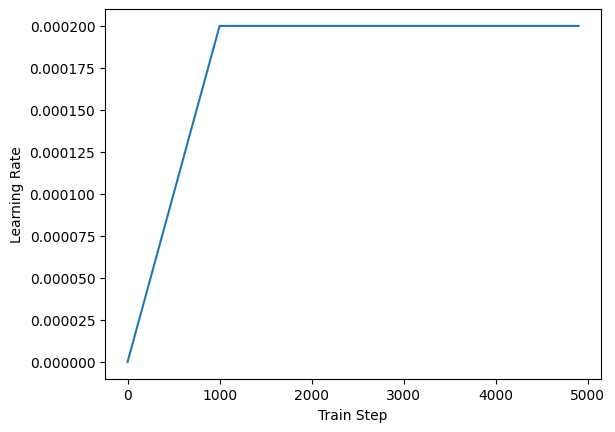

In [ ]:
import matplotlib.pyplot as plt

schedule = WarmupSchedule()
x = range(0, 5_000, 100)
y = [ops.convert_to_numpy(schedule(step)) for step in x]
plt.plot(x, y)
plt.xlabel("Train Step")
plt.ylabel("Learning Rate")
plt.show()

In [ ]:
num_epochs = 8
steps_per_epoch = num_train_batches // num_epochs
validation_steps = num_val_batches

mini_gpt.compile(
    optimizer=keras.optimizers.Adam(schedule),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
mini_gpt.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
)

Epoch 1/8
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 531s 129ms/step - accuracy: 0.0080 - loss: 10.5699 - val_accuracy: 0.0094 - val_loss: 10.5687
Epoch 2/8
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 455s 126ms/step - accuracy: 0.0081 - loss: 10.5699 - val_accuracy: 0.0094 - val_loss: 10.5687
Epoch 3/8
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 455s 126ms/step - accuracy: 0.0080 - loss: 10.5702 - val_accuracy: 0.0094 - val_loss: 10.5687
Epoch 4/8
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 456s 126ms/step - accuracy: 0.0080 - loss: 10.5697 - val_accuracy: 0.0094 - val_loss: 10.5687
Epoch 5/8
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 456s 126ms/step - accuracy: 0.0080 - loss: 10.5700 - val_accuracy: 0.0094 - val_loss: 10.5687
Epoch 6/8
 876/3609 ━━━━━━━━━━━━━━━━━━━━ 5:32 122ms/step - accuracy: 0.0078 - loss: 10.5695

In [ ]:
def generate(prompt, max_length=64):
    tokens = list(ops.convert_to_numpy(tokenizer(prompt)))
    prompt_length = len(tokens)
    for _ in range(max_length - prompt_length):
        prediction = mini_gpt(ops.convert_to_numpy([tokens]))
        prediction = ops.convert_to_numpy(prediction[0, -1])
        tokens.append(np.argmax(prediction).item())
    return tokenizer.detokenize(tokens)

In [ ]:
prompt = "A piece of advice"
generate(prompt)

In [ ]:
def compiled_generate(prompt, max_length=64):
    tokens = list(ops.convert_to_numpy(tokenizer(prompt)))
    prompt_length = len(tokens)
    tokens = tokens + [0] * (max_length - prompt_length)
    for i in range(prompt_length, max_length):
        prediction = mini_gpt.predict(np.array([tokens]), verbose=0)
        prediction = prediction[0, i - 1]
        tokens[i] = np.argmax(prediction).item()
    return tokenizer.detokenize(tokens)

In [ ]:
import timeit
tries = 10
timeit.timeit(lambda: compiled_generate(prompt), number=tries) / tries

In [ ]:
def compiled_generate(prompt, sample_fn, max_length=64):
    tokens = list(ops.convert_to_numpy(tokenizer(prompt)))
    prompt_length = len(tokens)
    tokens = tokens + [0] * (max_length - prompt_length)
    for i in range(prompt_length, max_length):
        prediction = mini_gpt.predict(np.array([tokens]), verbose=0)
        prediction = prediction[0, i - 1]
        next_token = ops.convert_to_numpy(sample_fn(prediction))
        tokens[i] = np.array(next_token).item()
    return tokenizer.detokenize(tokens)

In [ ]:
def greedy_search(preds):
    return ops.argmax(preds)

compiled_generate(prompt, greedy_search)

In [ ]:
def random_sample(preds, temperature=1.0):
    preds = preds / temperature
    return keras.random.categorical(preds[None, :], num_samples=1)[0]

In [ ]:
compiled_generate(prompt, random_sample)

In [ ]:
from functools import partial
compiled_generate(prompt, partial(random_sample, temperature=2.0))
compiled_generate(prompt, partial(random_sample, temperature=0.8))
compiled_generate(prompt, partial(random_sample, temperature=0.2))

In [ ]:
def top_k(preds, k=5, temperature=1.0):
    preds = preds / temperature
    top_preds, top_indices = ops.top_k(preds, k=k, sorted=False)
    choice = keras.random.categorical(top_preds[None, :], num_samples=1)[0]
    return ops.take_along_axis(top_indices, choice, axis=-1)

In [ ]:
compiled_generate(prompt, partial(top_k, k=5))
compiled_generate(prompt, partial(top_k, k=20))

In [ ]:
compiled_generate(prompt, partial(top_k, k=5, temperature=0.5))